# Daily minimum temperatures in ME
https://www.kaggle.com/datasets/kankanashukla/daily-minimum-temperatures-in-me

In [49]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [67]:
df2=pd.read_csv("/Users/philippebeliveau/Desktop/Bureau/Notebook_Jupyter_R/Fuzzy_TS_Conformal_Prediction/Fuzzy_FTS/Electricity_data/daily-minimum-temperatures-in-me.csv")

In [68]:
df2.head()

,Date,Daily minimum temperatures
0,1/1/1981,20.7
1,1/2/1981,17.9
2,1/3/1981,18.8
3,1/4/1981,14.6
4,1/5/1981,15.8


In [51]:
df2['Date']=pd.to_datetime(df2['Date'])

df2.index=df2['Date']

df2.drop('Date',axis=1,inplace=True)

df2 = df2.dropna()

df2 = df2[df2['Daily minimum temperatures'] != 0]

In [52]:
df2['Daily minimum temperatures']=pd.to_numeric(df2['Daily minimum temperatures'],errors='coerce')

In [6]:
df2

,Daily minimum temperatures
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8
...,...
1990-12-27,14.0
1990-12-28,13.6
1990-12-29,13.5


<AxesSubplot: xlabel='Date'>

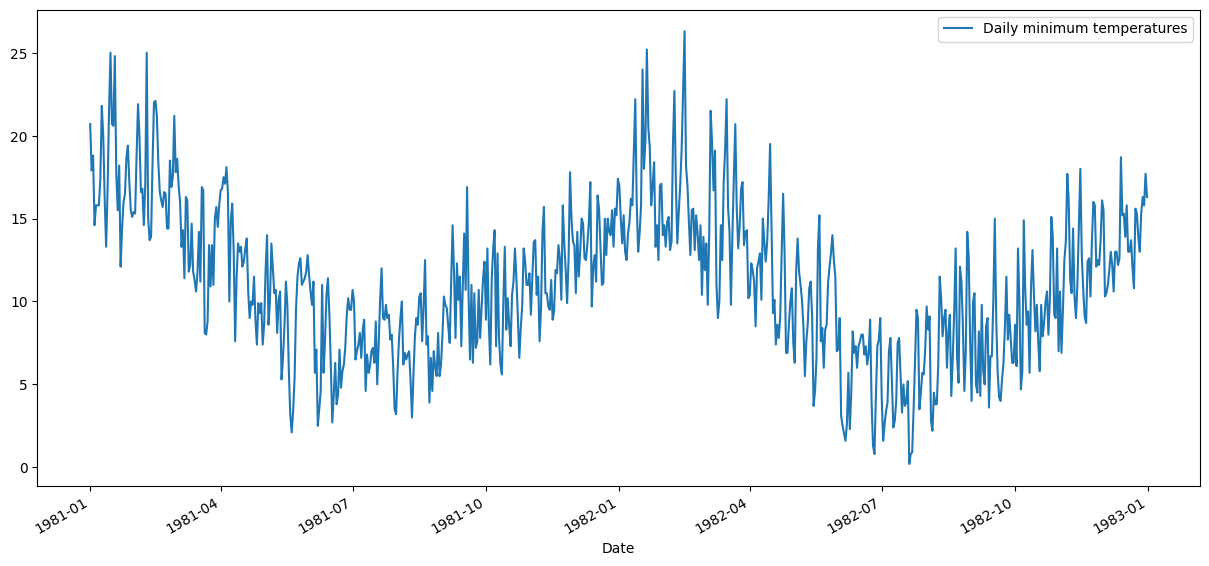

In [53]:
x=df2.loc['1980':'1982']

x.plot(figsize=(15,7))

In [54]:
list = [x]
data = np.concatenate(list).ravel().tolist()

# Weighted permutation entropy
https://github.com/arthurpessa/ordpy
Parameters: 
- data (array) – Array object in the format 
- dx (int) – Embedding dimension (horizontal axis) (default: 3).
- dy (int) – Embedding dimension (vertical axis); must be 1 for time series (default:1)

- taux (int) – Embedding delay (horizontal axis) (default: 1).

- tauy (int) – Embedding delay (vertical axis) (default: 1).

- base (str, int) – Logarithm base in Shannon’s entropy. Either ‘e’ or 2 (default: ‘e’).

- normalized (boolean) – If True, weighted permutation entropy is normalized by its maximum value. If False, it does not (default: True).

- tie_precision (None, int) – If not None, data is rounded with tie_precision decimal numbers (default: None).

In [38]:
import ordpy
from ordpy import weighted_permutation_entropy

entropy = weighted_permutation_entropy(data, dx = 3, dy = 1)
entropy

0.9219104207414278

# Transformation

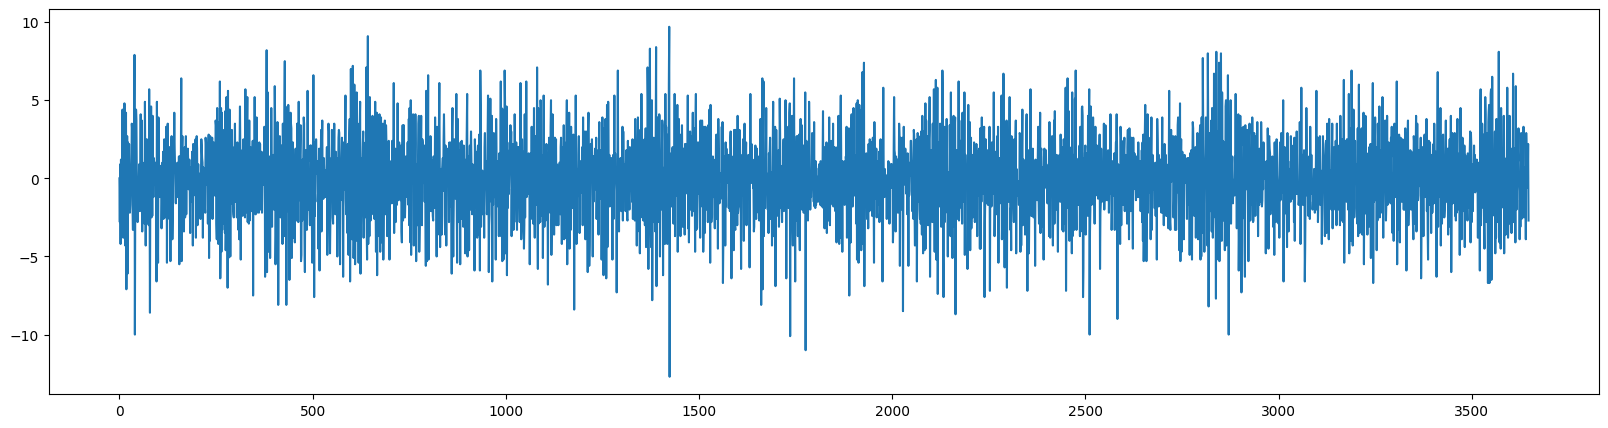

In [55]:
from pyFTS.common import Transformations

diff = Transformations.Differential(1)
fig = plt.subplots(figsize=(20,5))
plt.plot(diff.apply(df2['Daily minimum temperatures'].values), label="Temperature")
pass

# Data separation and modeling

In [56]:
train = df2.iloc[:3000]
test = df2.iloc[3001:3650]

uni_train = train["Daily minimum temperatures"].values

uni_test = test['Daily minimum temperatures'].values

In [57]:
from pyFTS.common import Util
from pyFTS.benchmarks import Measures
from pyFTS.partitioners import Grid,  Entropy #, Huarng
from pyFTS.models import hofts
from pyFTS.common import Membership as mf
from pyFTS.partitioners import CMeans, Grid, FCM, Huarng, Entropy, Util as pUtil
from pyFTS.data import Enrollments

,Partitions,RMSE,MAPE,U
0,5,2.53,22.75,1.00
1,10,2.60,22.28,1.03
2,15,2.53,22.86,1.00
3,20,2.56,23.55,1.01
4,25,2.52,22.80,1.00


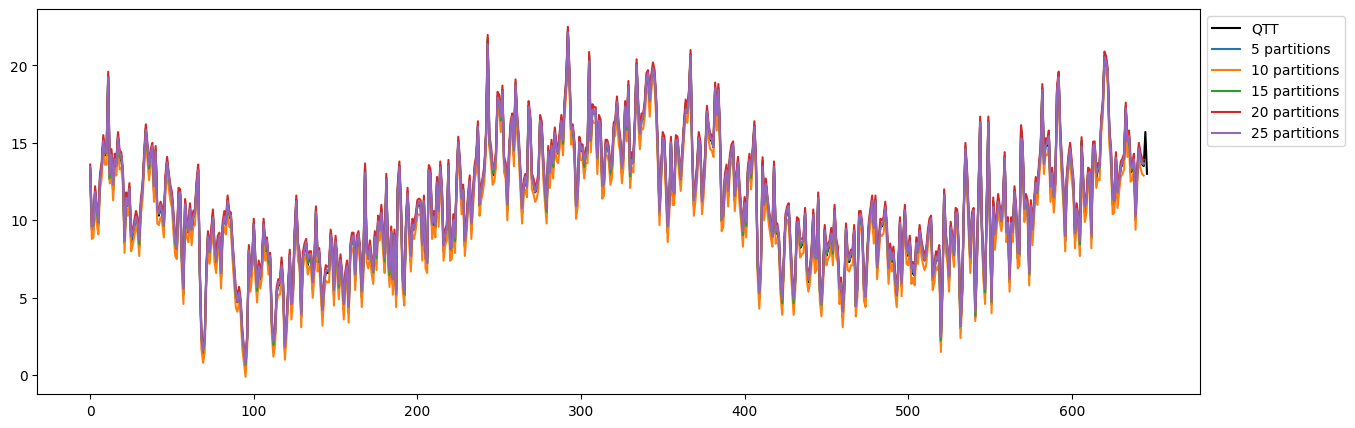

In [58]:
from pyFTS.models import hofts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures
rows = []


fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[15,5])

ax.plot(uni_test, label='QTT',color='black')

for npart in np.arange(5, 30, 5):
  part = CMeans.CMeansPartitioner(data=uni_train, npart=npart, transformation=diff)
  model = hofts.HighOrderFTS(order=1, partitioner=part)
  model.append_transformation(diff)  
  model.fit(uni_train)
  forecasts = model.predict(uni_test)
    
  ax.plot(forecasts[:-1], label=str(npart) + " partitions")
  
  rmse, mape, u = Measures.get_point_statistics(uni_test, model)
  
  rows.append([npart, rmse, mape, u])
  

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))

pd.DataFrame(rows, columns=['Partitions','RMSE','MAPE','U'])

# Question 
1. What is the effect of the partioning technique on the performance and the fit of the model?
2. I though I would see more overfitting as I increased the number of partitions, but it seems pretty stable

# Observation 
1. From changing the partioning from Grid.Gridpartionner to Cmeans, the partitions 5 went from the worst to the best performing. 

In [32]:
print(model)

Probabilistic FTS:
(0.01) A1 -> (0.012)A10, (0.081)A11, (0.119)A12, (0.036)A13, (0.015)A15, (0.032)A16, (0.064)A17, (0.021)A18, (0.018)A19, (0.026)A2, (0.025)A20, (0.025)A3, (0.089)A4, (0.063)A5, (0.056)A6, (0.113)A7, (0.144)A8, (0.061)A9
(0.04) A10 -> (0.047)A10, (0.051)A11, (0.053)A12, (0.051)A13, (0.023)A14, (0.032)A15, (0.055)A16, (0.071)A17, (0.032)A18, (0.026)A19, (0.073)A2, (0.01)A20, (0.073)A3, (0.07)A4, (0.087)A5, (0.066)A6, (0.041)A7, (0.082)A8, (0.056)A9
(0.046) A11 -> (0.005)A1, (0.041)A10, (0.044)A11, (0.071)A12, (0.039)A13, (0.026)A14, (0.04)A15, (0.047)A16, (0.05)A17, (0.077)A18, (0.03)A19, (0.056)A2, (0.014)A20, (0.053)A3, (0.083)A4, (0.069)A5, (0.083)A6, (0.067)A7, (0.056)A8, (0.048)A9
(0.044) A12 -> (0.004)A1, (0.04)A10, (0.058)A11, (0.047)A12, (0.042)A13, (0.032)A14, (0.023)A15, (0.061)A16, (0.032)A17, (0.038)A18, (0.032)A19, (0.048)A2, (0.014)A20, (0.071)A3, (0.118)A4, (0.072)A5, (0.062)A6, (0.071)A7, (0.066)A8, (0.07)A9
(0.031) A13 -> (0.016)A1, (0.047)A10, (0.035)

,Order,RMSE,MAPE,U
0,1,2.52,22.62,1.00
1,2,2.58,23.81,1.02
2,3,2.72,24.20,1.08


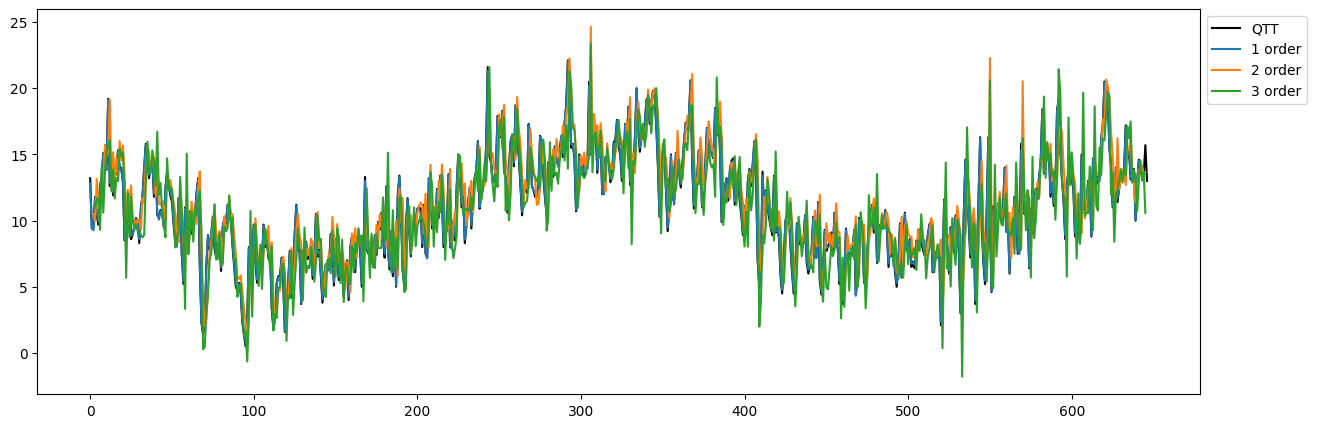

In [59]:
from pyFTS.models import hofts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures
rows = []

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[15,5])

ax.plot(uni_test, label='QTT',color='black')

for order in np.arange(1,4):
  part = CMeans.CMeansPartitioner(data=uni_train, npart=25, transformation=diff)
  model = hofts.HighOrderFTS(order=order, partitioner=part)
  model.append_transformation(diff)  
  model.fit(uni_train)
  forecasts = model.predict(uni_test)
  if order > 1:
    for k in np.arange(order):
      forecasts.insert(0,None)

  ax.plot(forecasts[:-1], label=str(order) + " order")
  
  rmse, mape, u = Measures.get_point_statistics(uni_test, model)
  
  rows.append([order, rmse, mape, u])
  

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))

pd.DataFrame(rows, columns=['Order','RMSE','MAPE','U'])

,Model,RMSE,MAPE,U
0,WHOFTS,2.52,23.20,1.00
1,PWFTS,2.49,22.69,0.99


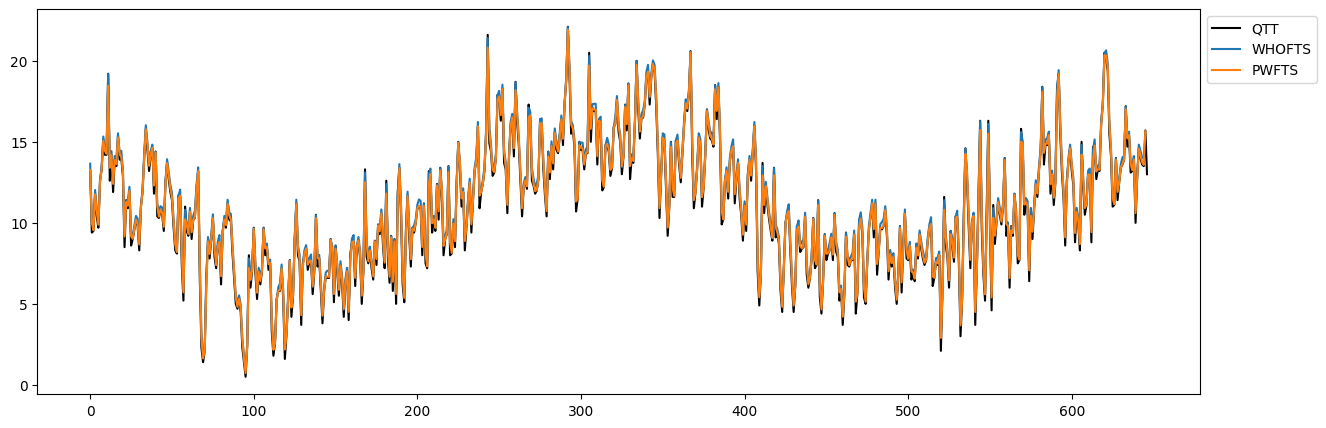

In [62]:
from pyFTS.models import hofts, pwfts
from pyFTS.partitioners import Grid
from pyFTS.benchmarks import Measures
rows = []

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[15,5])

ax.plot(uni_test, label='QTT',color='black')

part = CMeans.CMeansPartitioner(data=uni_train, npart=5, transformation=diff)

for method in [hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS]:
  model = method(order=1, partitioner=part)
  model.append_transformation(diff)  
  model.fit(uni_train)
  forecasts = model.predict(uni_test)

    
  ax.plot(forecasts[:-1], label=model.shortname)
  
  rmse, mape, u = Measures.get_point_statistics(uni_test, model)
  
  rows.append([model.shortname, rmse, mape, u])
  

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))

pd.DataFrame(rows, columns=['Model','RMSE','MAPE','U'])

## Final Fuzzy model

In [64]:
model

# ARIMA

In [157]:
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import  seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from matplotlib import ticker
from matplotlib.ticker import MaxNLocator, IndexFormatter
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape


In [51]:
def stationarity_check(ts):
            
    # Calculate rolling statistics
    roll_mean = ts.rolling(window=8, center=False).mean()
    roll_std = ts.rolling(window=8, center=False).std()

    # Perform the Dickey Fuller test
    dftest = adfuller(ts) 
    
    # Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(ts, color='blue',label='Original')
    mean = plt.plot(roll_mean, color='red', label='Rolling Mean')
    std = plt.plot(roll_std, color='green', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results

    print('\nResults of Dickey-Fuller Test: \n')


    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

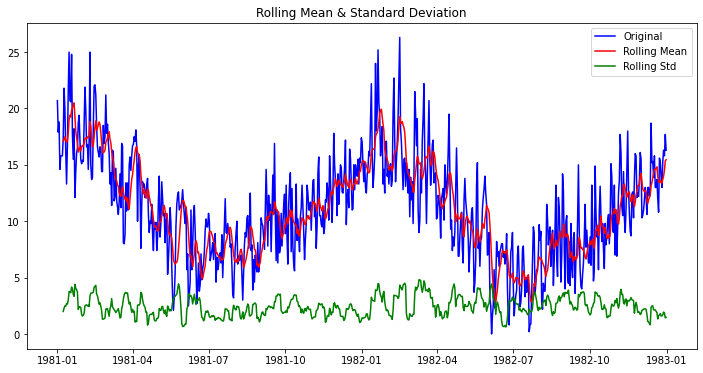


Results of Dickey-Fuller Test: 

Test Statistic                  -2.106925
p-value                          0.241739
#Lags Used                      18.000000
Number of Observations Used    711.000000
Critical Value (1%)             -3.439581
Critical Value (5%)             -2.865614
Critical Value (10%)            -2.568939
dtype: float64


In [52]:
stationarity_check(x)

# Observations 
Here we see that we do not have a stationary series as the p-value is larger than 0.05. 

# What to do
- Lets start with a differencing, but before lets visualize the trend and seasonality, this could give us insight in how many differencing to perform. 

In [142]:
def decomposition_plot(ts):
# Apply seasonal_decompose 
    decomposition = seasonal_decompose(np.log(ts), period=365)
    
# Get trend, seasonality, and residuals
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

# Plotting
    plt.figure(figsize=(12,8))
    plt.subplot(411)
    plt.plot(np.log(ts), label='Original', color='blue')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend', color='blue')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality', color='blue')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals', color='blue')
    plt.legend(loc='best')
    plt.tight_layout()


# Decomposition

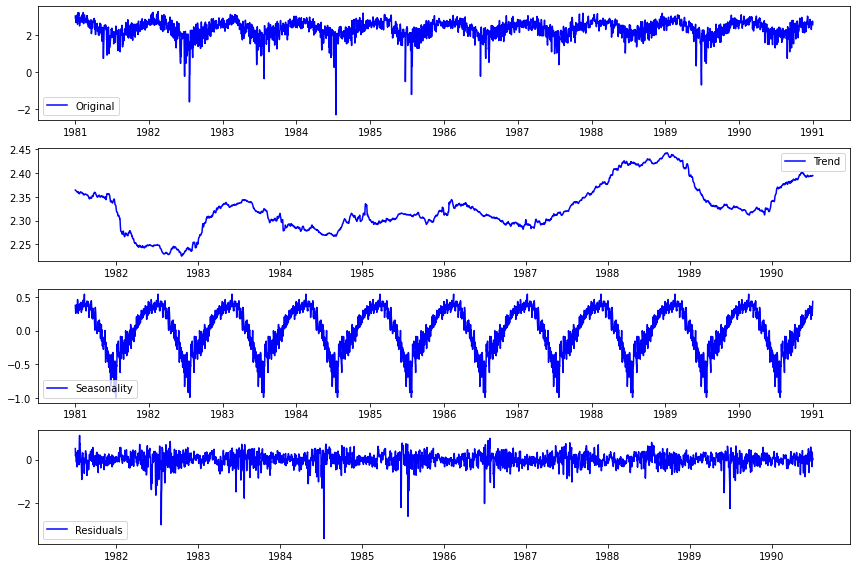

In [143]:
decomposition_plot(df2)

## Questions 
- How to read that seasonality?
- How to work with the periodicity? 
## Observations
- Here we would have to define the periodicity in terms of the dicker fuller test and aditive vs multiplicative model: https://towardsdatascience.com time-series-decomposition-and-statsmodels-parameters-69e54d035453

# Plot autocorrelation

In [161]:
def plot_acf_pacf(ts, figsize=(10,8),lags=24):
    
    fig,ax = plt.subplots(nrows=3, figsize=figsize)
    
    # Plot ts
    ts.plot(ax=ax[0])
    
    # Plot acf, pavf
    plot_acf(ts, ax=ax[1], lags=lags)
    plot_pacf(ts, ax=ax[2], lags=lags) 
    fig.tight_layout()
    
    for a in ax[1:]:
        a.xaxis.set_major_locator(plt.ticker.MaxNLocator(min_n_ticks=lags, integer=True))
        a.xaxis.grid()
    return fig,ax

AttributeError: module 'matplotlib.pyplot' has no attribute 'ticker'

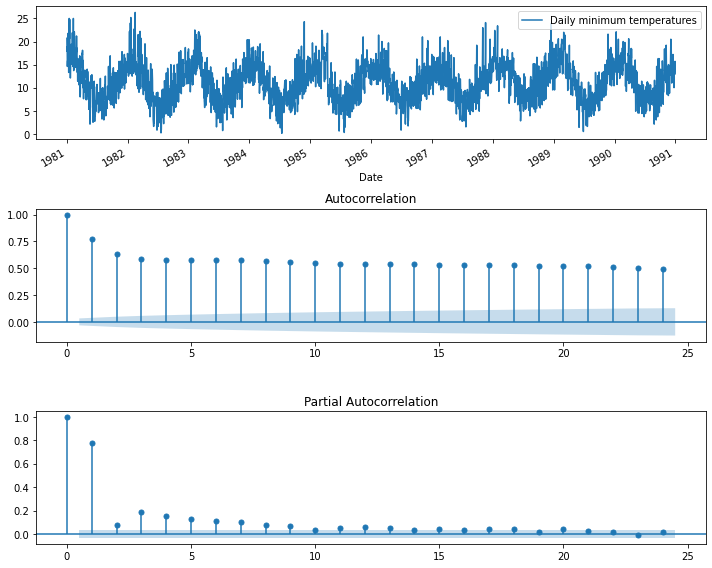

In [162]:
plot_acf_pacf(df2)

## Observations
- We are seeing significant autocorrelation
- It is expected, as we are playing with temperature data

In [171]:
auto = auto_arima(uni_train, seasonal=True, stepwise=True, start_p=0, start_q=0)
auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3000
Model:               SARIMAX(3, 0, 1)   Log Likelihood               -6935.248
Date:                Mon, 29 May 2023   AIC                          13882.496
Time:                        17:14:59   BIC                          13918.534
Sample:                             0   HQIC                         13895.458
                               - 3000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0529      0.019      2.739      0.006       0.015       0.091
ar.L1          1.4858      0.020     73.479      0.000       1.446       1.525
ar.L2         -0.6196      0.029    -21.121      0.000      -0.677      -0.562
ar.L3          0.1293      0.019      6.644      0.000       0.091       0.167
ma.L1         -0.8958      0.013    -71.108      0.000      -0.921      -0.871
sigma2         5.9594      0.145     41.130      0.000       5.675       6.243
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                13.44
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                             0.08
Prob(H) (two-sided):                  0.12   Kurtosis:                         3.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

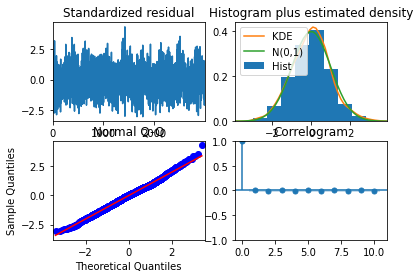

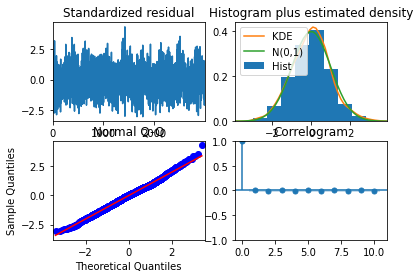

In [172]:
auto.plot_diagnostics()

In [173]:
model = auto  # seeded from the model we've already fit

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=7, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in uni_test:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)

print(f"Mean squared error: {mean_squared_error(uni_test, forecasts)}")
print(f"SMAPE: {smape(uni_test, forecasts)}")

Mean squared error: 4.979346721228455
SMAPE: 18.262937778706345


# Conformal prediction
Parameters: 
- We need to specify the mehtods (method = "EnbPI") for time series forecasting
- The cross validation method (cv = "BlockBootstrap") must be set to this as it is more suited to time series.

### EnbPI method
The EnbPI method allows you update the residuals during the prediction, each time new observations are available so that the deterioration of predictions, or the increase of noise level, can be dynamically taken into account. It can be done with MapieTimeSeriesRegressor through the partial_fit class method called at every step.
[1] Chen Xu and Yao Xie. “Conformal Prediction Interval for Dynamic Time-Series.” International Conference on Machine Learning (ICML, 2021).
https://slideslive.com/38958681/conformal-prediction-interval-for-dynamic-timeseries?ref=speaker-43618-latest

EnbPI method seems to only deal with one step forecast

In [40]:
import warnings

import numpy as np
import pandas as pd
from matplotlib import pylab as plt
from scipy.stats import randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

from mapie.metrics import (regression_coverage_score,
                           regression_mean_width_score)
from mapie.subsample import BlockBootstrap
from mapie.regression import MapieTimeSeriesRegressor

warnings.simplefilter("ignore")

### Approach 
Estimating prediction intervals can be possible in two ways:

- with a regular .fit and .predict process, limiting the use of trainining set residuals to build prediction intervals

- using .partial_fit in addition to .fit and .predict allowing MAPIE to use new residuals from the test points as new data are becoming available.

The latter method is particularly useful to adjust prediction intervals to sudden change points on test sets that have not been seen by the model during training.

In [65]:
alpha = 0.05
gap = 1
cv_mapiets = BlockBootstrap(
    n_resamplings=100, length=48, overlapping=True, random_state=59
)
mapie_enbpi = MapieTimeSeriesRegressor(
    model, method="enbpi", cv=cv_mapiets, agg_function="mean", n_jobs=-1
)

### Without partial fit

In [66]:
mapie_enbpi = mapie_enbpi.fit(uni_train)
y_pred_npfit, y_pis_npfit = mapie_enbpi.predict(
    uni_test, alpha=alpha, ensemble=True, optimize_beta=True
)
coverage_npfit = regression_coverage_score(
    uni_test, y_pis_npfit[:, 0, 0], y_pis_npfit[:, 1, 0]
)
width_npfit = regression_mean_width_score(
    y_pis_npfit[:, 0, 0], y_pis_npfit[:, 1, 0]
)

TypeError: fit() missing 1 required positional argument: 'y'

### With partial fit

In [ ]:
mapie_enbpi = mapie_enbpi.fit(uni_train)

y_pred_pfit = np.zeros(y_pred_npfit.shape)
y_pis_pfit = np.zeros(y_pis_npfit.shape)
conformity_scores_pfit = []
lower_quantiles_pfit = []
higher_quantiles_pfit = []
y_pred_pfit[:gap], y_pis_pfit[:gap, :, :] = mapie_enbpi.predict(
    X_test.iloc[:gap, :], alpha=alpha, ensemble=True, optimize_beta=True
)
for step in range(gap, len(X_test), gap):
    mapie_enbpi.partial_fit(
        X_test.iloc[(step - gap):step, :],
        y_test.iloc[(step - gap):step],
    )
    (
        y_pred_pfit[step:step + gap],
        y_pis_pfit[step:step + gap, :, :],
    ) = mapie_enbpi.predict(
        X_test.iloc[step:(step + gap), :],
        alpha=alpha,
        ensemble=True,
        optimize_beta=True
    )
    conformity_scores_pfit.append(mapie_enbpi.conformity_scores_)
    lower_quantiles_pfit.append(mapie_enbpi.lower_quantiles_)
    higher_quantiles_pfit.append(mapie_enbpi.higher_quantiles_)
coverage_pfit = regression_coverage_score(
    y_test, y_pis_pfit[:, 0, 0], y_pis_pfit[:, 1, 0]
)
width_pfit = regression_mean_width_score(
    y_pis_pfit[:, 0, 0], y_pis_pfit[:, 1, 0]
)

In [ ]:
y_preds = [y_pred_npfit, y_pred_pfit]
y_pis = [y_pis_npfit, y_pis_pfit]
coverages = [coverage_npfit, coverage_pfit]
widths = [width_npfit, width_pfit]

fig, axs = plt.subplots(
    nrows=2, ncols=1, figsize=(14, 8), sharey="row", sharex="col"
)
for i, (ax, w) in enumerate(zip(axs, ["without", "with"])):
    ax.set_ylabel("Hourly demand (GW)")
    ax.plot(
        y_train[int(-len(y_test)/2):],
        lw=2,
        label="Training data", c="C0"
    )
    ax.plot(y_test, lw=2, label="Test data", c="C1")

    ax.plot(
        y_test.index, y_preds[i], lw=2, c="C2", label="Predictions"
    )
    ax.fill_between(
        y_test.index,
        y_pis[i][:, 0, 0],
        y_pis[i][:, 1, 0],
        color="C2",
        alpha=0.2,
        label="Prediction intervals",
    )
    title = f"EnbPI, {w} update of residuals. "
    title += f"Coverage:{coverages[i]:.3f} and Width:{widths[i]:.3f}"
    ax.set_title(title)
    ax.legend()
fig.tight_layout()
plt.show()

### Investigate the coverage

In [ ]:
window = 24
rolling_coverage_pfit, rolling_coverage_npfit = [], []
for i in range(window, len(y_test), 1):
    rolling_coverage_pfit.append(
        regression_coverage_score(
            y_test[i-window:i], y_pis_pfit[i-window:i, 0, 0],
            y_pis_pfit[i-window:i, 1, 0]
        )
    )
    rolling_coverage_npfit.append(
        regression_coverage_score(
            y_test[i-window:i], y_pis_npfit[i-window:i, 0, 0],
            y_pis_npfit[i-window:i, 1, 0]
        )
    )

plt.figure(figsize=(10, 5))
plt.ylabel(f"Rolling coverage [{window} hours]")
plt.plot(
    y_test[window:].index,
    rolling_coverage_npfit,
    label="Without update of residuals"
)
plt.plot(
    y_test[window:].index,
    rolling_coverage_pfit,
    label="With update of residuals"
)
plt.show()